In [1]:
import warnings
warnings.filterwarnings('ignore')

from collections import OrderedDict
from time import time

import numpy as np
import pandas as pd
import pandas_datareader.data as web

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

from logbook import Logger, StderrHandler, INFO

from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import AverageDollarVolume, EWMA, Returns
from zipline.pipeline.factors.technical import RSI, MACDSignal, TrueRange
from zipline import run_algorithm
from zipline.api import (attach_pipeline, pipeline_output,
                         date_rules, time_rules,
                         schedule_function, commission, slippage,
                         set_slippage, set_commission,
                         record,
                         order_target, order_target_percent)

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

sns.set_style('whitegrid')

log_handler = StderrHandler(
        format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                      '{record.level_name}: {record.func_name}: {record.message}',
        level=INFO
)
log_handler.push_application()
log = Logger('Algorithm')

N_LONGS = 25
N_SHORTS = 25
MIN_POSITIONS = 15
UNIVERSE = 250
TRAINING_PERIOD = 252 * 2
N_FORWARD_DAYS = 1
TRADE_FREQ = date_rules.every_day()
def make_universe():
    # Set screen
    dollar_volume = AverageDollarVolume(window_length=90)
    return dollar_volume.top(UNIVERSE)
universe = make_universe()

#start = pd.Timestamp('2015-01-01', tz='UTC')
#end = pd.Timestamp('2017-12-31', tz='UTC')
start = pd.Timestamp('2015-01-01')
end = pd.Timestamp('2017-12-31')

In [2]:
def Price_Momentum_3M():
    return Returns(window_length=63)

def Returns_39W():
    return Returns(window_length=215)

class Vol_3M(CustomFactor):
    inputs = [Returns(window_length=2)]
    window_length = 63

    def compute(self, today, assets, out, rets):
        out[:] = np.nanstd(rets, axis=0)
        
class Mean_Reversion_1M(CustomFactor):
    inputs = [Returns(window_length=21)]
    window_length = 252

    def compute(self, today, assets, out, monthly_rets):
        out[:] = (monthly_rets[-1] - np.nanmean(monthly_rets, axis=0)) / np.nanstd(monthly_rets, axis=0)
        
class Moneyflow_Volume_5d(CustomFactor):
    inputs = [USEquityPricing.close, USEquityPricing.volume]
    window_length = 5
    def compute(self, today, assets, out, close, volume):
        mfvs = []
        for col_c, col_v in zip(close.T, volume.T):
            denominator = np.dot(col_c, col_v)
            numerator = 0.
            for n, price in enumerate(col_c.tolist()):
                if price > col_c[n - 1]:
                    numerator += price * col_v[n]
                else:
                    numerator -= price * col_v[n]
            mfvs.append(numerator / denominator)
        out[:] = mfvs
        
class Trendline(CustomFactor):
    inputs = [USEquityPricing.close]
    window_length = 252

    def compute(self, today, assets, out, close):
        X = np.arange(self.window_length).reshape(-1, 1).astype(float)
        X -= X.mean()
        Y = close - np.nanmean(close, axis=0)
        out[:] = (X.T @ Y / np.var(X)) / self.window_length
        
class Price_Oscillator(CustomFactor):
    inputs = [USEquityPricing.close]
    window_length = 252

    def compute(self, today, assets, out, close):
        four_week_period = close[-20:]
        out[:] = (np.nanmean(four_week_period, axis=0) / np.nanmean(close, axis=0)) - 1.
        
vol_3M = Vol_3M()
mean_reversion_1M = Mean_Reversion_1M()
macd_signal_10d = MACDSignal()
moneyflow_volume_5d = Moneyflow_Volume_5d()
trendline = Trendline()
price_oscillator = Price_Oscillator()
price_momentum_3M = Price_Momentum_3M()
returns_39W = Returns_39W()
true_range = TrueRange() #Indicates the true degree of daily price change in an underlying
features = {
    'Vol 3M'             : vol_3M,
    'Mean Reversion 1M'  : mean_reversion_1M,
    'MACD Signal 10d'    : macd_signal_10d,
    'Moneyflow Volume 5D': moneyflow_volume_5d,
    'Trendline'          : trendline,
    'Price Oscillator'   : price_oscillator,
    'Price Momentum 3M'  : price_momentum_3M,
    '39 Week Returns'    : returns_39W,
    'True Range'         : true_range
}

In [3]:
class LinearModel(CustomFactor):
    """Obtain model predictions"""
    train_on_weekday = [0, 2, 4]

    def __init__(self, *args, **kwargs):
        super().__init__(self, *args, **kwargs)

        self._scaler = StandardScaler()
        self._model = SGDRegressor(penalty='l2')
        self._trained = False

    def _train_model(self, today, returns, inputs):
        scaler = self._scaler
        model = self._model

        shift_by = N_FORWARD_DAYS + 1
        outcome = returns[shift_by:].flatten()
        features = np.dstack(inputs)[:-shift_by]
        n_days, n_stocks, n_features = features.shape
        features = features.reshape(-1, n_features)
        features = features[~np.isnan(outcome)]
        outcome = outcome[~np.isnan(outcome)]
        outcome = outcome[np.all(~np.isnan(features), axis=1)]
        features = features[np.all(~np.isnan(features), axis=1)]
        features = scaler.fit_transform(features)

        start = time()
        model.fit(X=features, y=outcome)
        self._trained = True

    def _maybe_train_model(self, today, returns, inputs):
        if (today.weekday() in self.train_on_weekday) or not self._trained:
            self._train_model(today, returns, inputs)

    def compute(self, today, assets, out, returns, *inputs):
        self._maybe_train_model(today, returns, inputs)

        X = np.dstack(inputs)[-1]
        missing = np.any(np.isnan(X), axis=1)
        X[missing, :] = 0
        X = self._scaler.transform(X)
        preds = self._model.predict(X)
        out[:] = np.where(missing, np.nan, preds)
        
def make_ml_pipeline(universe, window_length=21, n_forward_days=5):
    pipeline_columns = OrderedDict()
    pipeline_columns['Returns'] = Returns(inputs=[USEquityPricing.open],
                                          mask=universe,
                                          window_length=n_forward_days + 1)
    pipeline_columns.update({k: v.rank(mask=universe) for k, v in features.items()})
    pipeline_columns['predictions'] = LinearModel(inputs=pipeline_columns.values(), 
                                         window_length=window_length + n_forward_days,
                                         mask=universe)
    return Pipeline(screen=universe, columns=pipeline_columns)

def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    
    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerShare(cost=0, min_trade_cost=0))

    schedule_function(rebalance, TRADE_FREQ,
                      date_rules.every_day(),
                      time_rules.market_open(hours=1, minutes=30),
    )

    schedule_function(record_vars, date_rules.every_day(), time_rules.market_close())

    ml_pipeline = make_ml_pipeline(universe,
                                   n_forward_days=N_FORWARD_DAYS,
                                   window_length=TRAINING_PERIOD)

    # Create our dynamic stock selector.
    attach_pipeline(ml_pipeline, 'ml_model')

    context.past_predictions = {}
    context.ic = 0
    context.rmse = 0
    context.mae = 0
    context.returns_spread_bps = 0
    
def evaluate_predictions(output, context):
    # Look at past predictions to evaluate model performance
    # A day has passed, shift days and drop old ones
    context.past_predictions = {k - 1: v for k, v in context.past_predictions.items() if k > 0 }

    if 0 in context.past_predictions:
        
        # Use today's n-day returns to evaluate predictions
        #注意这里[0 in context.past_predictions]的含义：此处Returns是T的return，past_predictions[0]是T+1的
        returns, predictions = (output['Returns'].dropna()
                                .align(context.past_predictions[0].dropna(), join='inner')
                               )
        if len(returns) > 0 and len(predictions) > 0:
            context.ic = spearmanr(returns, predictions)[0]
            context.rmse = np.sqrt(mean_squared_error(returns, predictions))
            context.mae = mean_absolute_error(returns, predictions)

            long_rets = returns[predictions > 0].mean()
            short_rets = returns[predictions < 0].mean()
            context.returns_spread_bps = (long_rets - short_rets) * 10000

    # Store current predictions
    context.past_predictions[N_FORWARD_DAYS+1] = context.predicted_returns
    
def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('ml_model')
    context.predicted_returns = output['predictions']
    context.predicted_returns.index.set_names(['equity'], inplace=True)

    evaluate_predictions(output, context)

    # These are the securities that we are interested in trading each day.
    context.security_list = context.predicted_returns.index
    
def rebalance(context, data):
    """
    Execute orders according to our schedule_function() timing.
    """
    predictions = context.predicted_returns

    # Drop stocks that can not be traded
    predictions = predictions.loc[data.can_trade(predictions.index)]
    longs = (predictions[predictions > 0]
             .sort_values(ascending=False)[:N_LONGS]
             .index
             .tolist())
    shorts = (predictions[predictions < 0]
              .sort_values()[:N_SHORTS]
              .index
              .tolist())
    targets = set(longs + shorts)
    for position in context.portfolio.positions:
        if position not in targets:
            order_target(position, 0)
    
    n_longs, n_shorts = len(longs), len(shorts)
    if n_longs > MIN_POSITIONS and n_shorts > MIN_POSITIONS:
        for stock in longs:
            order_target_percent(stock, target=1/n_longs)
        for stock in shorts:
            order_target_percent(stock, target=-1/n_shorts)
    else:
        for stock in targets:
            if stock in context.portfolio.positions:
                order_target(stock, 0)
                
def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(
            leverage=context.account.leverage,
            ic=context.ic,
            rmse=context.rmse,
            mae=context.mae,
            returns_spread_bps=context.returns_spread_bps
    )

In [4]:
go = time()
results = run_algorithm(start=start,
                        end=end,
                        initialize=initialize,
                        before_trading_start=before_trading_start,
                        capital_base=1e6,
                        data_frequency='daily',
                        benchmark_returns=None,
                        bundle='quandl')

print('{:.2f}'.format(time()-go))

Cannot place order for EMC, as it has de-listed. Any existing positions for this asset will be liquidated on 2016-09-07 00:00:00.
Cannot place order for MDVN, as it has de-listed. Any existing positions for this asset will be liquidated on 2016-09-29 00:00:00.
Cannot place order for ARIA, as it has de-listed. Any existing positions for this asset will be liquidated on 2017-02-16 00:00:00.
Cannot place order for PNRA, as it has de-listed. Any existing positions for this asset will be liquidated on 2017-07-18 00:00:00.


342.77


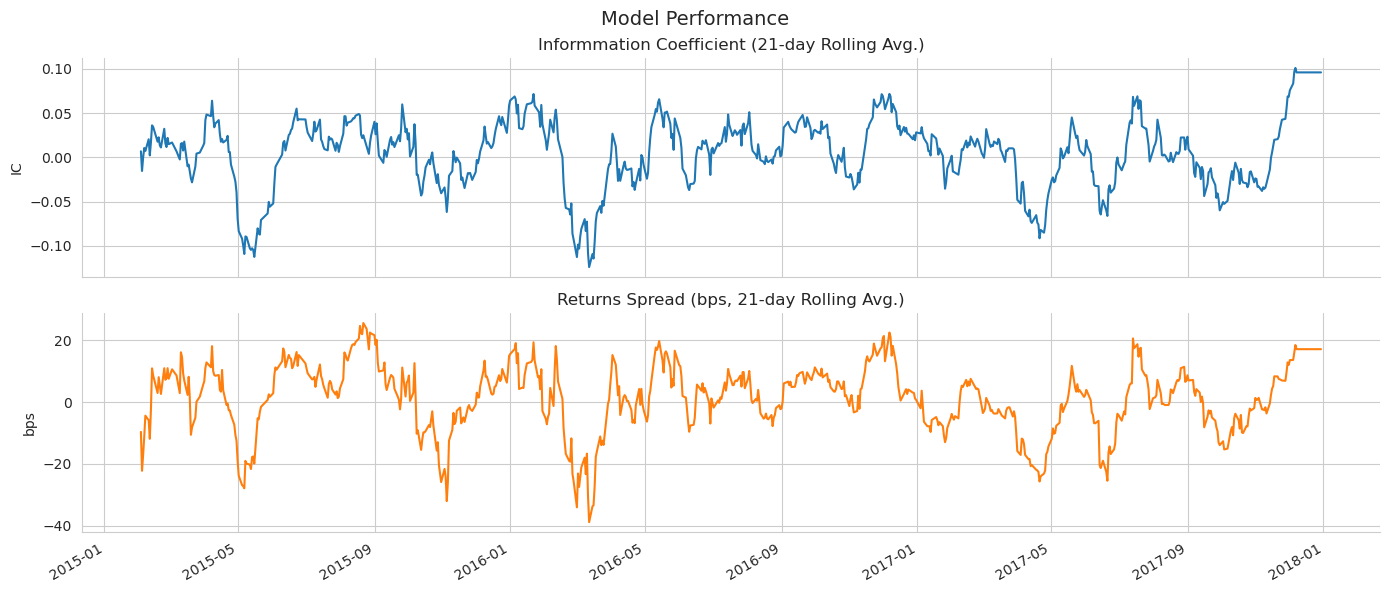

In [5]:
axes = (results[['ic', 'returns_spread_bps']]
        .dropna()
        .rolling(21)
        .mean()
        .plot(subplots=True, 
              layout=(2,1), 
              figsize=(14, 6), 
              title=['Informmation Coefficient (21-day Rolling Avg.)', 'Returns Spread (bps, 21-day Rolling Avg.)'],
              legend=False))
axes = axes.flatten()
axes[0].set_ylabel('IC')
axes[1].set_ylabel('bps')
plt.suptitle('Model Performance', fontsize=14)
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=.9);

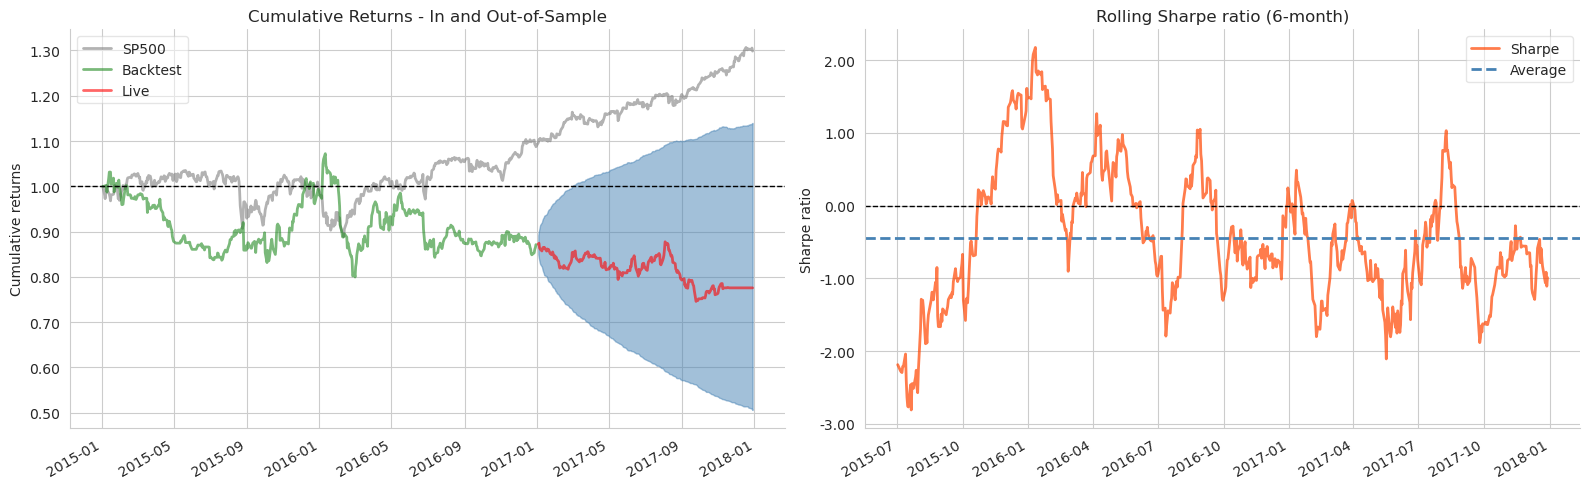

In [6]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark = web.DataReader('SP500', 'fred', '2014', '2018').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns,
                     factor_returns=benchmark,
                     live_start_date='2017-01-01',
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                    ax=axes[0])
plot_rolling_sharpe(returns, ax=axes[1])
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
sns.despine()
fig.tight_layout();

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.44,2016-01-11,2017-09-25,NaT,NaN
1,19.38,2015-01-14,2015-10-05,2016-01-07,257
2,1.39,2015-01-08,2015-01-09,2015-01-12,3
3,0.00,2015-01-02,2015-01-05,2015-01-06,3
4,NaN,NaT,NaT,NaT,NaN


ConversionError: Failed to convert value(s) to axis units: (NaT, Timestamp('2017-12-29 00:00:00+0000', tz='UTC'))

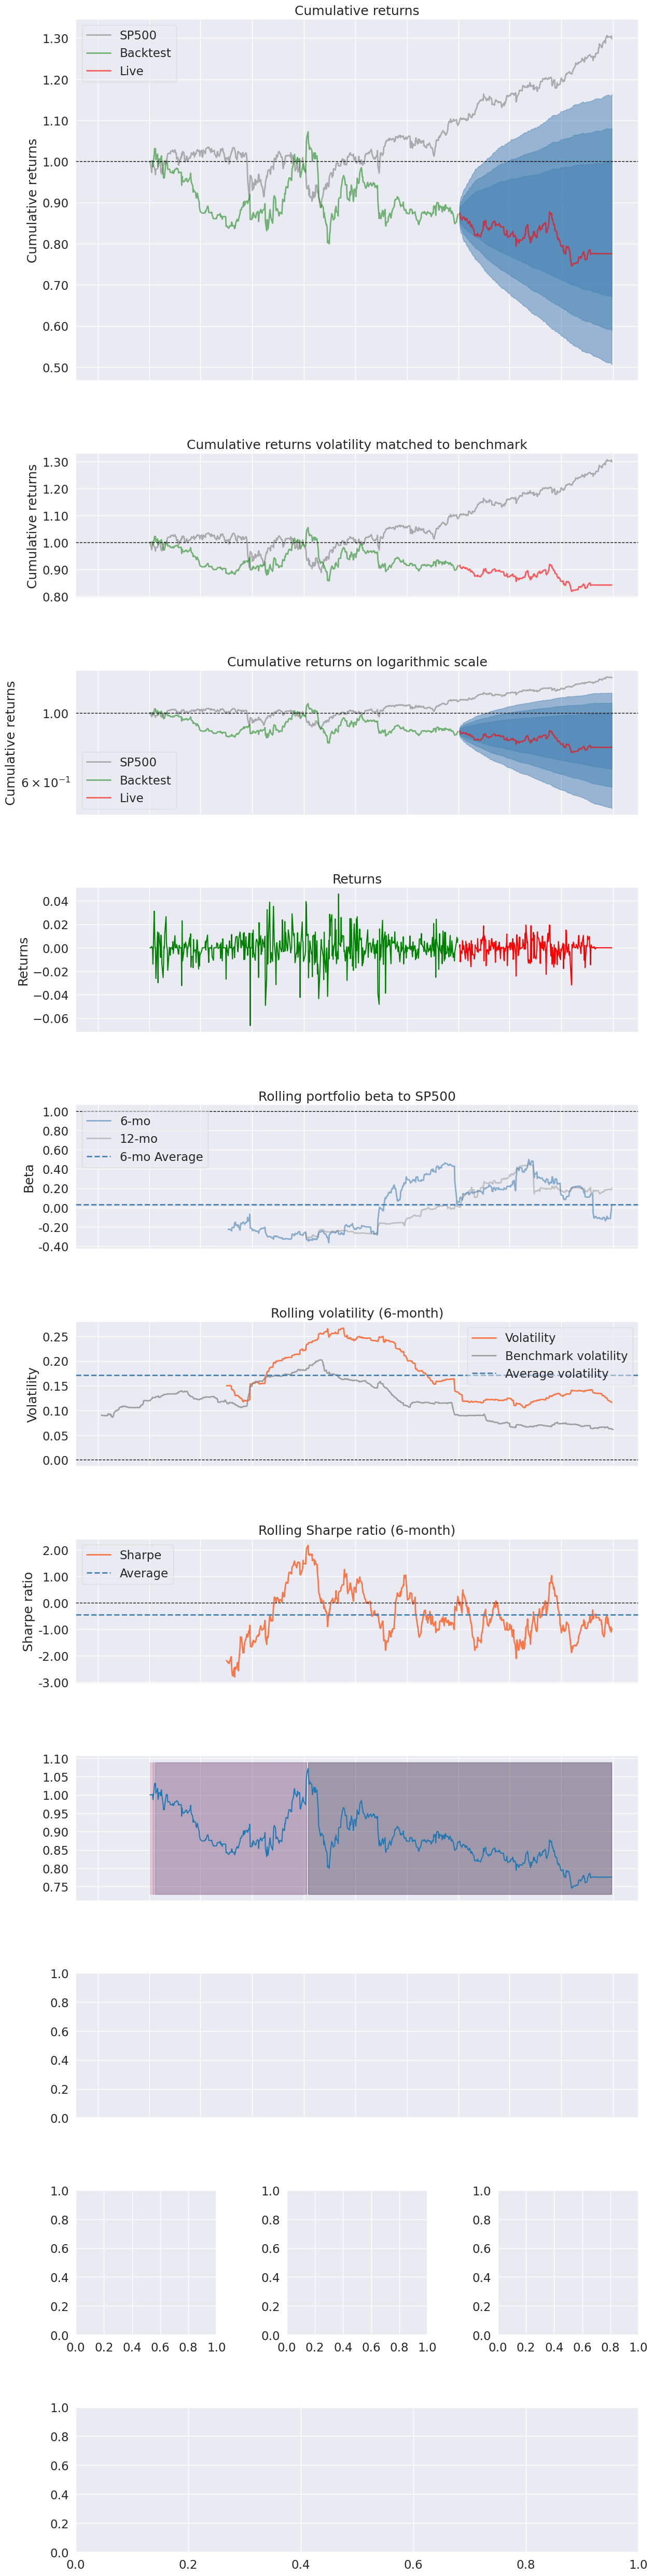

In [7]:
pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          live_start_date='2017-01-01', 
                          round_trips=True)